In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

from utils import *

In [2]:
import fastai
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [3]:
j = json.load(open('data/annotations.json'))

In [4]:
j[0]['annotations'][0]

{'class': 'fluke',
 'height': 372.0,
 'type': 'rect',
 'width': 1017.0,
 'x': 14.0,
 'y': 97.0}

The above annotations are in coco dataset format (x, y, width, height). The fastai library expects bbox coordinates to be in the format of (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin being in the upper left hand corner of the image.

In [5]:
SZ = 224
BS = 64
NUM_WORKERS = 12

In [6]:
def anno2bbox(anno):
    im_width, im_height = PIL.Image.open(f"data/train/{anno['filename']}").size
    anno = list(filter(lambda a: a['class'] == 'fluke', anno['annotations']))[0]
    return [
        np.clip(anno['y'], 0, im_height) / im_height * SZ,
        np.clip(anno['x'], 0, im_width) / im_width * SZ,
        np.clip(anno['y']+anno['height'], 0, im_height) / im_height * SZ,
        np.clip(anno['x']+anno['width'], 0, im_width) / im_width * SZ
    ]

Just some small functions that will be helpful as we construct our dataset.

In [7]:
fn2bbox = {jj['filename']: [[anno2bbox(jj)], ['fluke']] for jj in j}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
get_y_func = lambda o: fn2bbox[path2fn(o)]

In [8]:
val_fns = pd.read_pickle('data/val_fns_detection.pkl') # I create this file in fluke_detection.ipynb

ObjectCategoryList is designed to be used in a full object recognition scenario (multiple bounding boxes per image, objects of multiple classes). Since that is more functionality than we require (and more than our model will predict - our objects will always be of the same class, 'fluke', and we will be predicting just a single bounding box per image) I make minor changes to ObjectCategoryList.

In [9]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [10]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(fn2bbox.keys())), path='data/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)                         
        .label_from_func(get_y_func, label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

In [12]:
data.valid_ds.items

array(['data/train-224/./0dcfd05bf.jpg', 'data/train-224/./53bb428e9.jpg', 'data/train-224/./6ddd0e118.jpg',
       'data/train-224/./9b7b61f03.jpg', ..., 'data/train-224/./0050ef29d.jpg', 'data/train-224/./169b2ad65.jpg',
       'data/train-224/./8fb0f44ff.jpg', 'data/train-224/./c98cfffb6.jpg'], dtype='<U31')

In [13]:
batch = next(iter(data.valid_dl))

In [20]:
batch[0][0][1]

tensor([[1.9909, 1.9559, 1.9384,  ..., 1.9034, 1.9209, 1.9559],
        [1.8333, 1.8508, 1.9034,  ..., 1.8683, 1.9034, 1.9734],
        [1.6408, 1.7458, 1.8683,  ..., 1.7283, 1.8158, 1.9384],
        ...,
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
       device='cuda:0')

In [ ]:
data.valid_dl

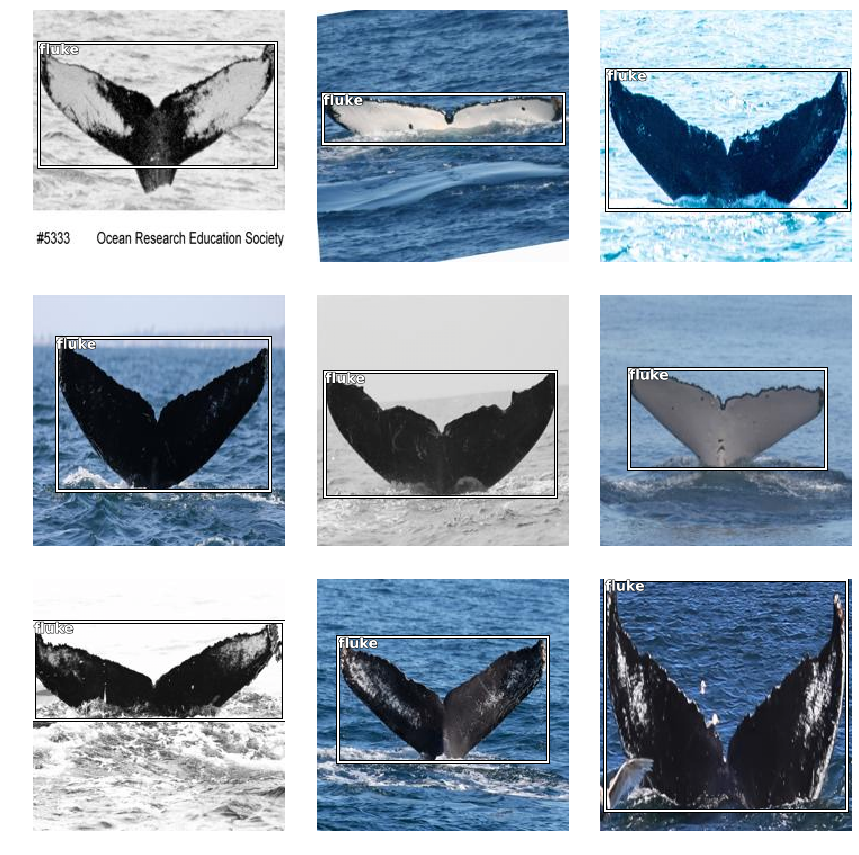

In [11]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

In [11]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [12]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [13]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [14]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [15]:
learn.freeze_to(-1)

In [16]:
%time learn.fit_one_cycle(25, 1e-2, div_factor=12, pct_start=0.2)

epoch     train_loss  valid_loss  <lambda>
1         0.759825    0.758315    0.004807  
2         0.692372    0.567173    0.177328  
3         0.510442    0.145664    0.668431  
4         0.371667    0.125010    0.699740  
5         0.285365    0.095039    0.759412  
6         0.227545    0.082278    0.767461  
7         0.186596    0.067472    0.810907  
8         0.155851    0.066130    0.811496  
9         0.133049    0.073339    0.767914  
10        0.117233    0.061547    0.821200  
11        0.104299    0.048268    0.857523  
12        0.093685    0.054305    0.838068  
13        0.084717    0.050066    0.851280  
14        0.077901    0.054723    0.834845  
15        0.072416    0.052774    0.842770  
16        0.067775    0.039757    0.877135  
17        0.063761    0.042438    0.873394  
18        0.059993    0.039957    0.879320  
19        0.057130    0.039642    0.878339  
20        0.054867    0.039929    0.880255  
21        0.052172    0.037646    0.885749  
22        0.

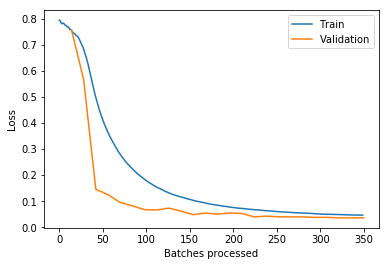

In [17]:
learn.recorder.plot_losses()

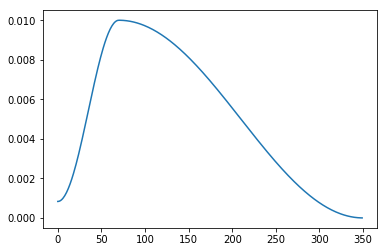

In [18]:
learn.recorder.plot_lr()

In [19]:
learn.unfreeze()

In [20]:
max_lr = 1e-3
lrs = np.array([max_lr/100, max_lr/10, max_lr])

In [21]:
%time learn.fit_one_cycle(120, lrs)

epoch     train_loss  valid_loss  <lambda>
1         0.041408    0.036024    0.891350  
2         0.041686    0.036643    0.888481  
3         0.042394    0.036223    0.889834  
4         0.042147    0.035488    0.891934  
5         0.042774    0.036509    0.889102  
6         0.042505    0.035741    0.892287  
7         0.041854    0.035105    0.892938  
8         0.041615    0.034806    0.893432  
9         0.041441    0.033503    0.897470  
10        0.041324    0.034279    0.895227  
11        0.041257    0.033792    0.899353  
12        0.040797    0.036583    0.891501  
13        0.040654    0.034592    0.894961  
14        0.040577    0.034002    0.896694  
15        0.040888    0.034287    0.895595  
16        0.040628    0.034160    0.896925  
17        0.040417    0.034762    0.894180  
18        0.040291    0.035749    0.893603  
19        0.040576    0.036981    0.892712  
20        0.041242    0.036121    0.893523  
21        0.041388    0.035178    0.895847  
22        0.

In [22]:
learn.save('fluke_detector')

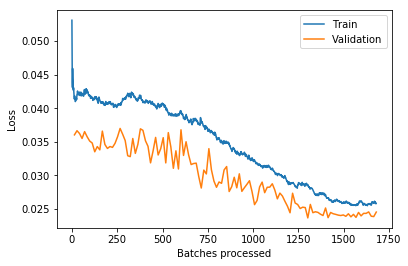

In [23]:
learn.recorder.plot_losses()

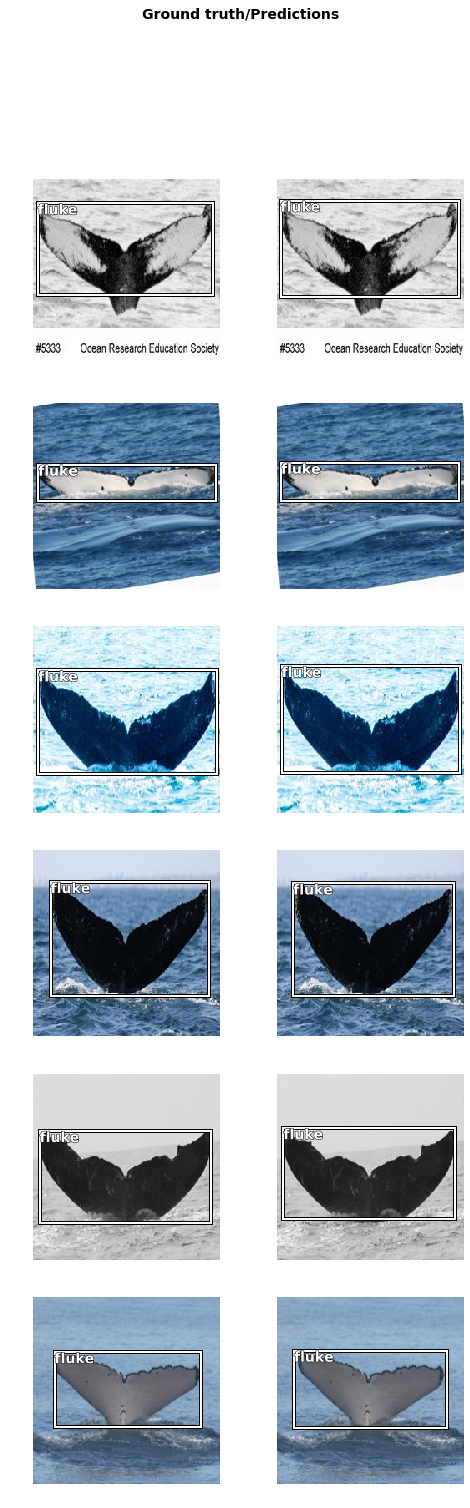

In [24]:
learn.show_results(rows=6)

In [ ]:
# preds, targs = learn.get_preds()

# predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()
# targets = ((targs + 1) / 2 * SZ).numpy().squeeze()

# def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
#     y_min, x_min, y_max, x_max = map(int, bbox)
#     cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
#     if target is not None:
#         y_min, x_min, y_max, x_max = map(int, target)
#         cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
#     return img

# def cv_read(path):    
#     im = cv2.imread(path, cv2.IMREAD_COLOR)
#     return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# # Targets are in green, predictions in red.
# ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(9)])
# plt.figure(figsize=(12,12))
# plt.axis('off')
# plt.imshow(montage(np.stack(ims), multichannel=True))